In [1]:
# Imports
import pandas as pd

from data_adapters.deribit_adapters import read_parquet, read_clean_jsonl  # -> [`data_adapters.deribit_adapters.read_parquet`](data_adapters/deribit_adapters.py)
from config import Algo1Config, DecoderKind               # -> [`config.Algo1Config`](config.py), [`config.DecoderKind`](config.py)
from pipeline.algo1 import run_algo1_deribit  

In [2]:
# Load your raw Deribit parquet
# data_path = "data/deribit_options_2025-01-30_100k_rows.parquet" 
# df_raw = read_parquet(data_path)

data_path = 'data/json/deribit_options_2025-05-22.jsonl'
df_raw = read_clean_jsonl(data_path)

# Configure and run
cfg = Algo1Config(
    n_tau=5,
    n_m=5,
    top_K=50,
    decoder=DecoderKind.HINGE_STATIC,  # or DecoderKind.PLS / DecoderKind.DEEP_PLS
    dda=1,
    dst=1,
    n_sa=1,
    seed=0,
    n_PC_sa=15,
    lam_hinge=1.0,
    price_scale=1.0
)

outs = run_algo1_deribit(df_raw, cfg, reference_date="2025-05-22", r=0.0, q=0.0)  # [`pipeline.algo1.Algo1Outputs`](pipeline/algo1.py)

# Quick checks
print("C_train shape:", outs.C_train.shape)
print("C_test  shape:", outs.C_test.shape)
print("Vega Weighted MAPE train/test:", outs.VW_MAPE_train, outs.VW_MAPE_test)
print("PSAS train/test:", outs.PSAS_train, outs.PSAS_test)

/Users/167011/Documents/GitHub/deribit_market_model/data_adapters/deribit_adapters.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['expiry'] = pd.to_datetime(df['expiry'])


[micro] start                  -> rows=409457, times=118193, taus=12
[micro] locked/crossed * spread -> rows=306805, times=98606, taus=12
[micro] stale                  -> rows=304987, times=97944, taus=12
[micro] depth                  -> rows=198502, times=75643, taus=12
[micro] tauguards              -> rows=25574, times=11629, taus=3
[micro] vega_guard             -> rows=23016, times=10940, taus=3


/Users/167011/Documents/GitHub/deribit_market_model/data_adapters/deribit_adapters.py:89: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  q_bid = df.groupby(tau_bin)['best_bid_amount'].transform(lambda s: s.quantile(micro.depth_q))
/Users/167011/Documents/GitHub/deribit_market_model/data_adapters/deribit_adapters.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  q_ask = df.groupby(tau_bin)['best_ask_amount'].transform(lambda s: s.quantile(micro.depth_q))
/Users/167011/Documents/GitHub/deribit_market_model/data_adapters/deribit_adapters.py:111: FutureWarning: The default of observed=False is deprecated and wi

[micro] MAD                    -> rows=22960, times=10923, taus=3


/Users/167011/Documents/GitHub/deribit_market_model/data_adapters/deribit_adapters.py:162: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, g in r2.groupby('mb'):
/Users/167011/Documents/GitHub/deribit_market_model/data_adapters/deribit_adapters.py:162: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, g in r2.groupby('mb'):
/Users/167011/Documents/GitHub/deribit_market_model/data_adapters/deribit_adapters.py:162: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt 

De-jump: removing 3444 timestamps (abs_thr=0.030, k_mad=6.0)
Option de-jump: removing 4360 timestamps (72.9%) [rel_thr=0.35, k_mad=8.0, frac_nodes>5.00%]
Option de-jump: removing 1314 timestamps (87.8%) [rel_thr=0.35, k_mad=8.0, frac_nodes>5.00%]


/Users/167011/Documents/GitHub/deribit_market_model/surfaces/derivatives.py:21: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  spline = SmoothBivariateSpline(τs, ms, Carr[t], kx=k_tau, ky=k_m, s=s)


C_train shape: (1623, 15)
C_test  shape: (182, 15)
Vega Weighted MAPE train/test: 0.12146713763109926 0.10913050365053109
PSAS train/test: 0.0 0.0


In [5]:
from pathlib import Path
import joblib

out_dir = Path("outputs/artifacts")
out_dir.mkdir(parents = True, exist_ok = True)

joblib.dump(outs, out_dir /"algo1_outs_2025-05-22.pkl")



['outputs/artifacts/algo1_outs_2025-05-22.pkl']

/Users/167011/Documents/GitHub/deribit_market_model/utils/visuals.py:162: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


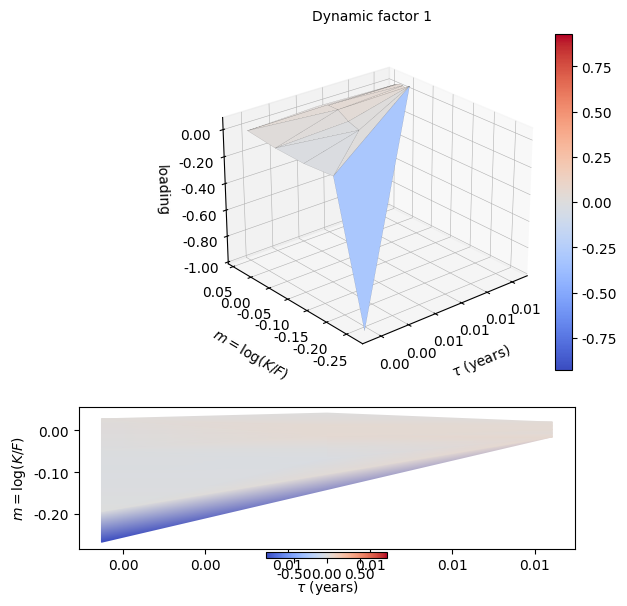

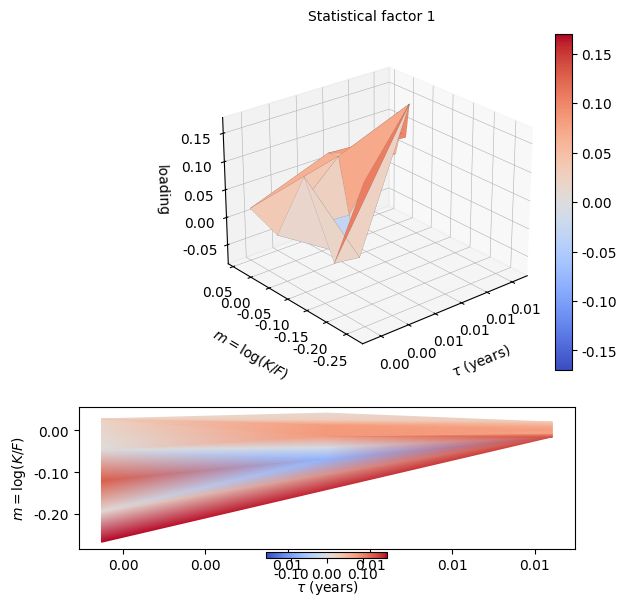

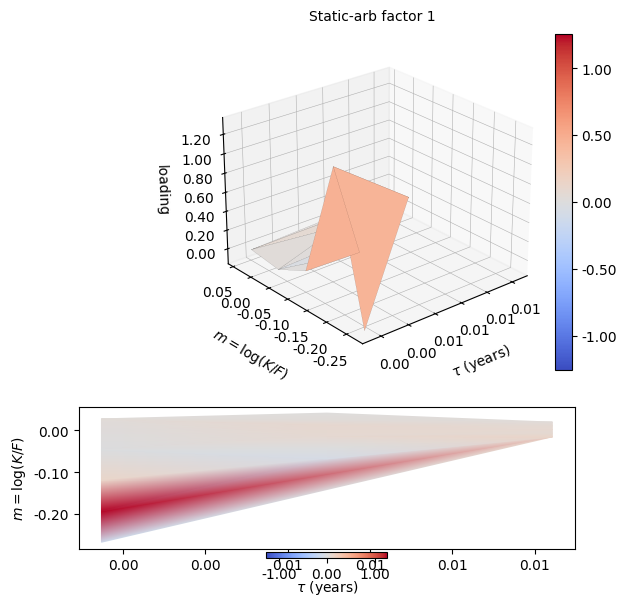

In [3]:
from utils.visuals import plot_factors_figure_731_style
# ===== Example usage once you have `out` from algorithm1_pipeline =====
plot_factors_figure_731_style(outs,
    which=("dyn","stat","sa"),
    elev=25, azim=230,              # camera angles; tweak if you need to match 1:1
    cmap="coolwarm",                # paper-like diverging colormap
    with_heatmaps=True,
    save_prefix="decoded"            # writes PNGs next to your script
)

(<Figure size 660x300 with 1 Axes>,
 <Axes: title={'center': '2-factor scores within static no-arb polygon'}, xlabel='$\\xi_s$', ylabel='$\\xi_a$'>)

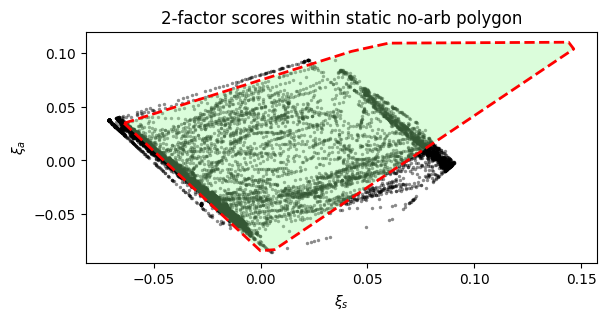

In [4]:
from utils.visuals import plot_threefactors_poly, plot_twofactor_polygon

plot_twofactor_polygon(outs)
# plot_threefactors_poly(outs)

In [13]:
outs.Xi_sa_test

array([[4.38082896],
       [2.81827644],
       [3.10767468],
       ...,
       [0.44859848],
       [0.4625158 ],
       [0.4764325 ]], shape=(2184, 1))